In [2]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from matplotlib.cm import ScalarMappable
from matplotlib import gridspec
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import pickle
import json
import os
import shutil
import sys
sys.path.append("..")

from main import *

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

with open("../swarmalatorlib/hex_colors.json", "r", encoding="utf-8") as f:
    hexColors = json.load(f)
hexCmap = mcolors.LinearSegmentedColormap.from_list("cmap", hexColors)


import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#C70000FF"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
cmap_r = mcolors.LinearSegmentedColormap.from_list("my_colormap", colors[::-1])

colors = ["#403990", "#80A6E2", "#F46F43", "#CF3D3E"]
cmap2 = mcolors.LinearSegmentedColormap.from_list("cmap2", colors)

SAVE_PATH = r"F:\MS_ExperimentData\general"
MP4_PATH = r"F:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"


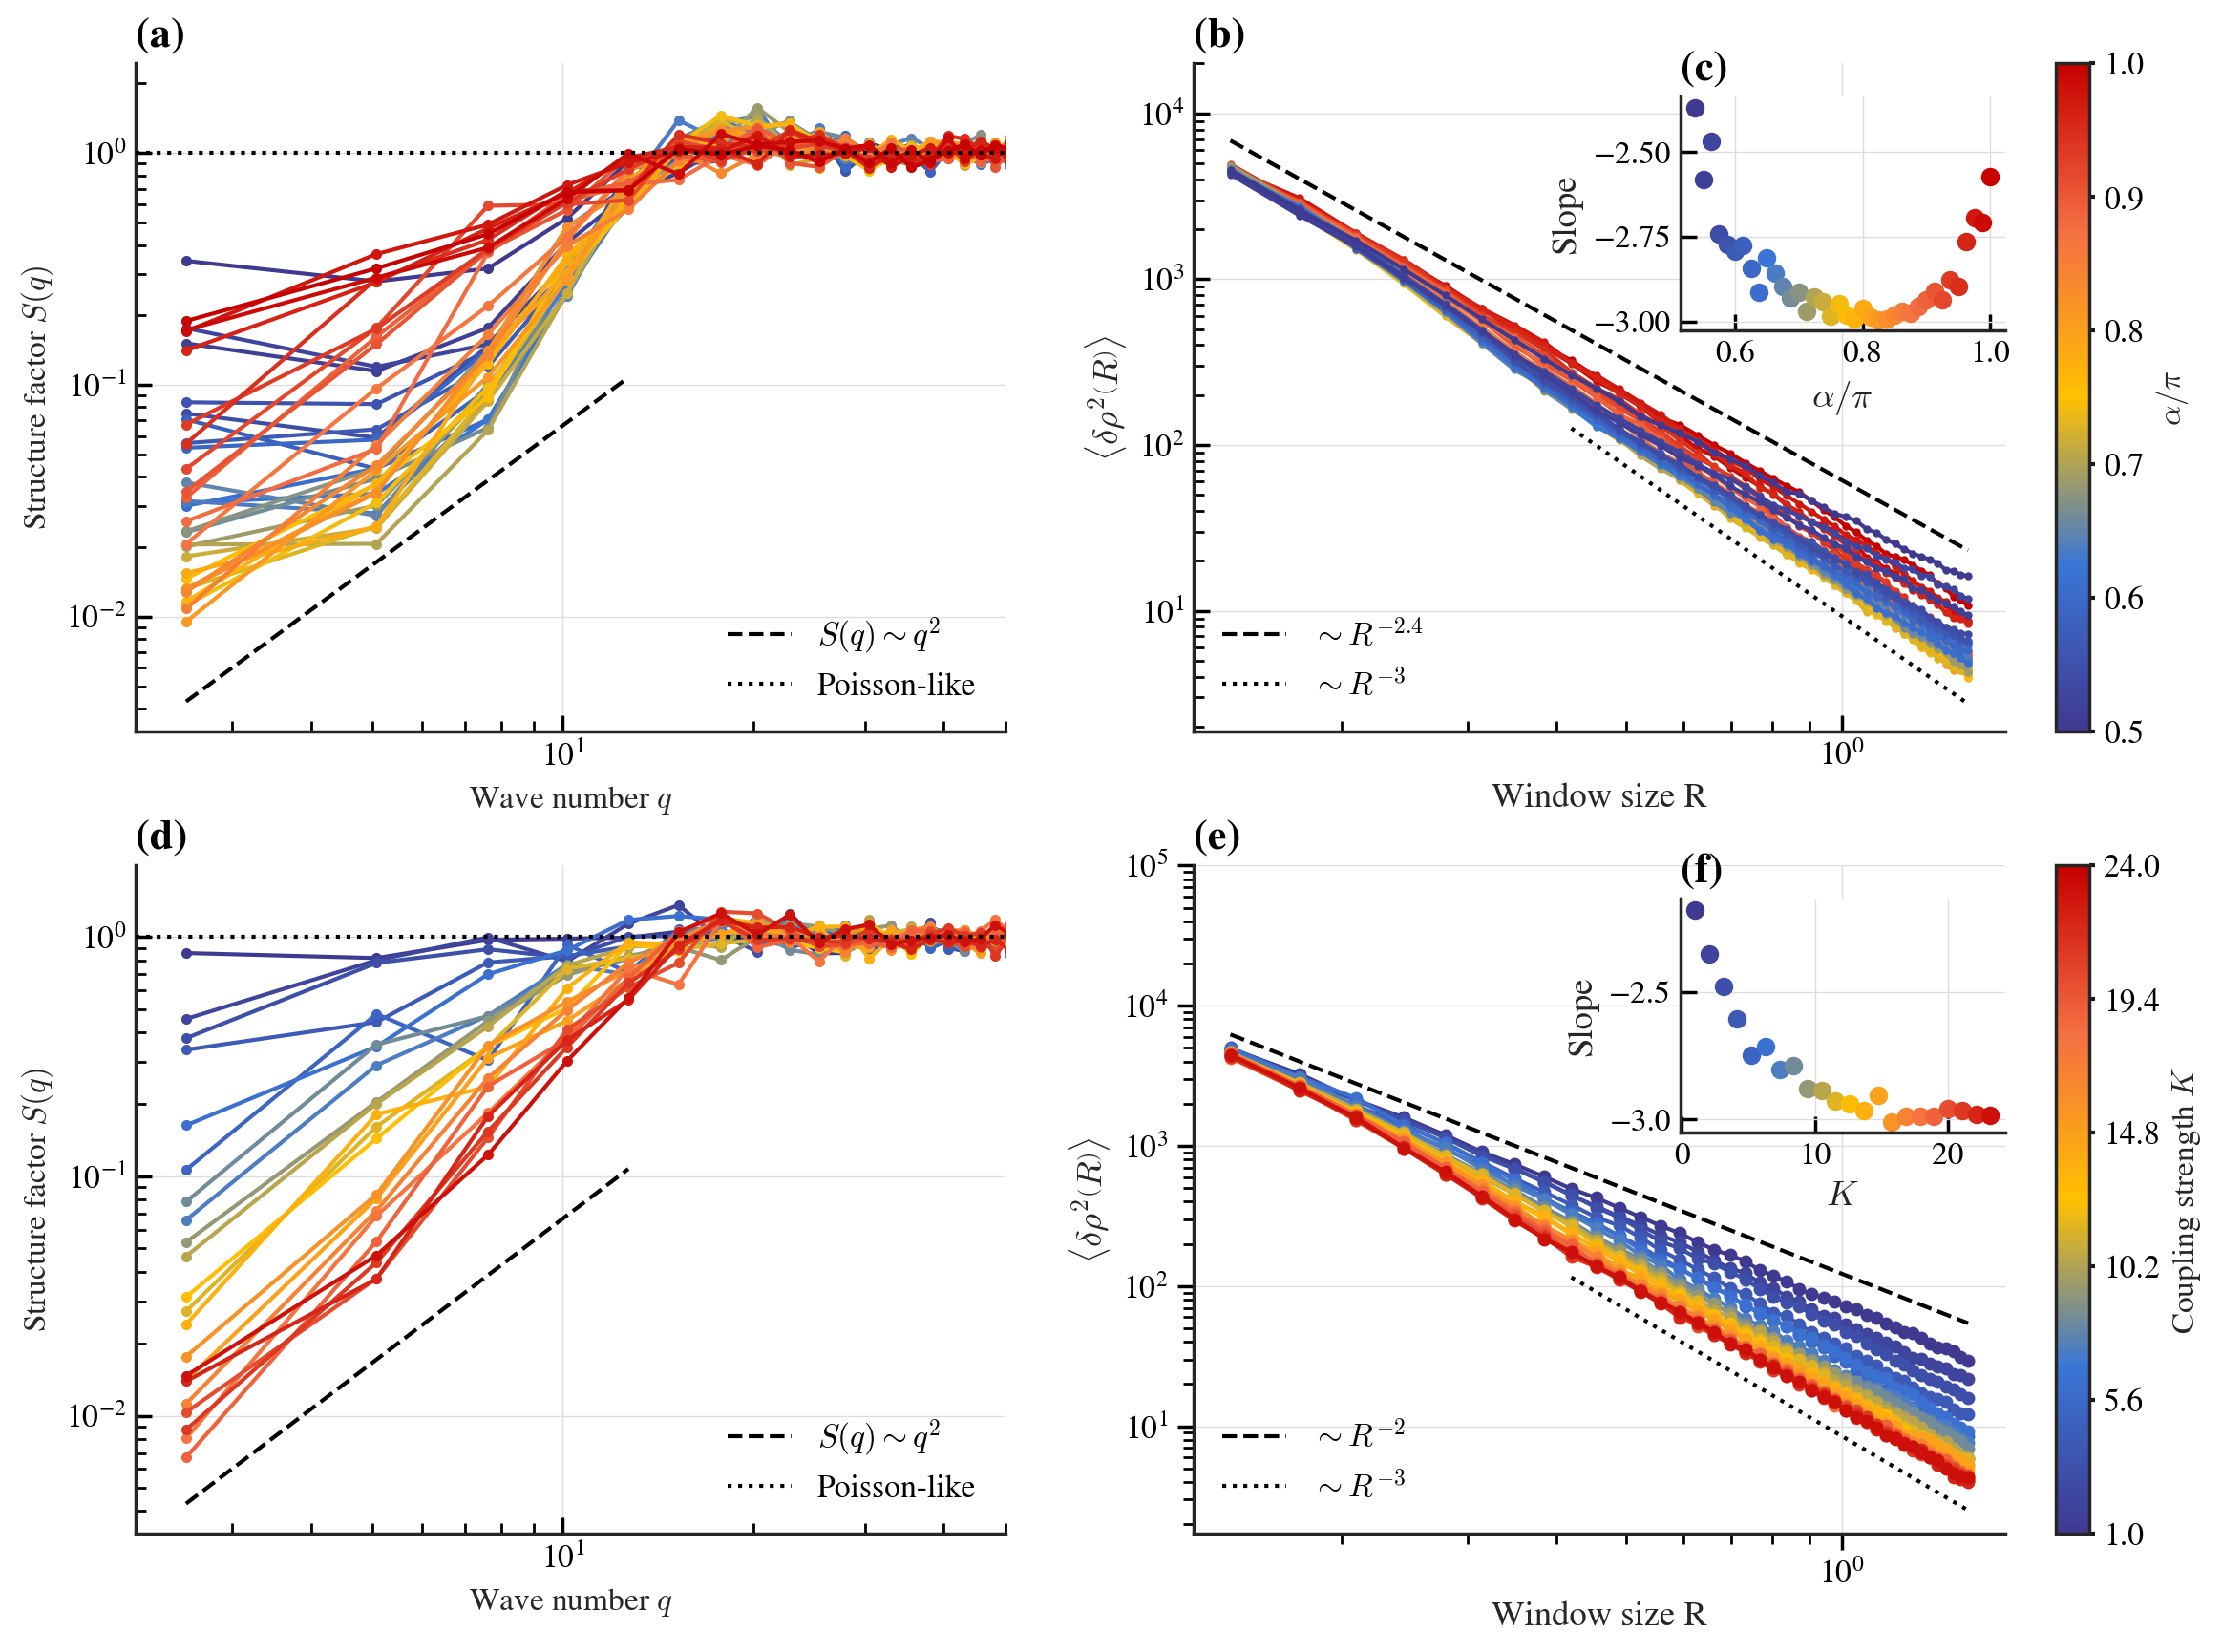

In [22]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.linear_model import LinearRegression

system_size = 7
num_particles = 5000
rho_0 = num_particles / (system_size**2)

# =========================================================================
fig, axs = plt.subplots(2, 2, figsize=(14, 10), width_ratios=[6, 7])
ax: plt.Axes = axs[0, 0]
ax.set_title("(a)", loc="left", fontsize=16, fontweight="bold")
with open(f"temp/mean_Sqs_dict_vary_A_K{24}.pkl", "rb") as f:
    mean_Sqs_dict = pickle.load(f)

selectedAlphas = np.linspace(0.5, 1, 41)[3:] * np.pi

for params, (qs, Sqs) in mean_Sqs_dict.items():
    phaseLagA = params[2]
    if phaseLagA not in selectedAlphas:
        continue

    color = cmap((phaseLagA - min(selectedAlphas)) / (max(selectedAlphas) - min(selectedAlphas)))

    qs, Sqs = np.array(qs), np.array(Sqs)
    
    q_bins = np.linspace(qs.min(), qs.max(), 40)
    Sqs_binned = np.zeros((len(q_bins)-1, 2))
    for i in range(len(q_bins)-1):
        mask = (qs >= q_bins[i]) & (qs < q_bins[i+1])
        if np.any(mask):
            Sqs_binned[i, 0] = np.mean(Sqs[mask])
            Sqs_binned[i, 1] = np.std(Sqs[mask]) / np.sqrt(np.sum(mask))

    qValues = 0.5 * (q_bins[:-1] + q_bins[1:])
    ax.plot(
        qValues, Sqs_binned[:, 0],
        marker="o", markersize=3, 
        color=color
    )

qValues = 0.5 * (q_bins[:-1] + q_bins[1:])[:5]
power_law = 2
ax.plot(qValues, np.array(qValues) ** power_law / 1500, '--', color="black", 
         markersize=2, linewidth=1.5, label=rf'$S(q) \sim q^{power_law}$')

ax.axhline(1, color='black', linestyle=':', label="Poisson-like", zorder=100)
ax.set_xlabel('Wave number $q$', fontsize=12)
ax.set_ylabel('Structure factor $S(q)$', fontsize=12)
ax.semilogx()
ax.semilogy()
ax.legend(frameon=False, loc="lower right")
ax.grid()
ax.tick_params(which='both', direction="in")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(None, 50)

# =========================================================================
ax: plt.Axes = axs[0, 1]
ax.set_title("(b)", loc="left", fontsize=16, fontweight="bold")
with open(f"temp/mean_variance_rho_dict_vary_A_K{24}.pkl", "rb") as f:
    mean_variance_rho_dict = pickle.load(f)

insertAx: plt.Axes = ax.inset_axes([0.6, 0.6, 0.4, 0.35])
insertAx.set_title("(c)", loc="left", fontsize=16, fontweight="bold")
insertAx.tick_params(which='both', direction="in", labelsize=12)
insertAx.grid()
insertAx.set_ylabel("Slope")
insertAx.set_xlabel(r'$\alpha / \pi$')
insertAx.spines['top'].set_visible(False)
insertAx.spines['right'].set_visible(False)

selectedAlphas = np.linspace(0.5, 1, 41)[3:] * np.pi

stdVarianceRho = list(mean_variance_rho_dict.values())[0][1][0]

for params, (l_values, variance_rho) in mean_variance_rho_dict.items():
    phaseLagA = params[2]
    if phaseLagA not in selectedAlphas:
        continue

    color = cmap((phaseLagA - min(selectedAlphas)) / (max(selectedAlphas) - min(selectedAlphas)))
    ax.loglog(l_values, variance_rho, 'o-', markersize=2, alpha=1, 
              zorder=1000 + int(-phaseLagA*100), color=color)

    logLValues = np.log(l_values).reshape(-1, 1)
    logVarianceValues = np.log(variance_rho).reshape(-1, 1)
    slope = LinearRegression().fit(logLValues, logVarianceValues).coef_[0][0]
    insertAx.scatter(phaseLagA / np.pi, slope, color=color)

power_law = 2.4
ax.loglog(l_values, rho_0 / (l_values**power_law) * 0.6, '--', color="black", 
          label=r'$\sim R^{' + str(-power_law) + '}$')


power_law = 3
sub_l_values = l_values[l_values >= 0.4]
ax.loglog(sub_l_values, rho_0 / (sub_l_values**power_law) / 11, ':', color="black", 
          label=r'$\sim R^{' + str(-power_law) + '}$')

ax.set_xlabel('Window size R')
ax.set_ylabel(r'$\langle \delta \rho ^2\left( R \right) \rangle$')
ax.grid(True, zorder=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False, loc="lower left")
ax.tick_params(which='both', direction="in")
ax.set_ylim(None, 20000)

norm = plt.Normalize(0.5, 1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = plt.colorbar(sm, ax=ax, ticks=np.linspace(0.5, 1, 6))
cbar1.set_label(r'$\alpha / \pi$', fontsize=12)
cbar1.ax.tick_params(length=2, direction="out", color="k", width=1.5)

# =========================================================================
ax: plt.Axes = axs[1, 0]
ax.set_title("(d)", loc="left", fontsize=16, fontweight="bold")
with open(f"temp/mean_Sqs_dict_vary_K_d0{0.25}_A{0.8 * np.pi}.pkl", "rb") as f:
    mean_Sqs_dict = pickle.load(f)

strengthKs = np.linspace(1, 39, 37)
selectedKs = strengthKs[strengthKs <= 24]

for params, (qs, Sqs) in mean_Sqs_dict.items():
    strengthK = params[0]
    if strengthK not in selectedKs:
        continue

    color = cmap((strengthK - 1) / (24 - 1))

    qs, Sqs = np.array(qs), np.array(Sqs)
    
    q_bins = np.linspace(qs.min(), qs.max(), 40)
    Sqs_binned = np.zeros((len(q_bins)-1, 2))
    for i in range(len(q_bins)-1):
        mask = (qs >= q_bins[i]) & (qs < q_bins[i+1])
        if np.any(mask):
            Sqs_binned[i, 0] = np.mean(Sqs[mask])
            Sqs_binned[i, 1] = np.std(Sqs[mask]) / np.sqrt(np.sum(mask))

    qValues = 0.5 * (q_bins[:-1] + q_bins[1:])
    ax.plot(
        qValues, Sqs_binned[:, 0],
        marker="o", markersize=3, 
        color=color
    )

qValues = 0.5 * (q_bins[:-1] + q_bins[1:])[:5]
power_law = 2
ax.plot(qValues, np.array(qValues) ** power_law / 1500, '--', color="black", 
         markersize=2, linewidth=1.5, label=rf'$S(q) \sim q^{power_law}$')

ax.axhline(1, color='black', linestyle=':', label="Poisson-like", zorder=100)
ax.set_xlabel('Wave number $q$', fontsize=12)
ax.set_ylabel('Structure factor $S(q)$', fontsize=12)
ax.semilogx()
ax.semilogy()
ax.legend(frameon=False, loc="lower right")
ax.grid()
ax.tick_params(which='both', direction="in")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim(None, 50)

# =========================================================================
ax: plt.Axes = axs[1, 1]
ax.set_title("(e)", loc="left", fontsize=16, fontweight="bold")
with open(f"temp/mean_variance_rho_dict_vary_K_d0{0.25}_A{0.8 * np.pi}.pkl", "rb") as f:
    mean_variance_rho_dict = pickle.load(f)

insertAx: plt.Axes = ax.inset_axes([0.6, 0.6, 0.4, 0.35])
insertAx.set_title("(f)", loc="left", fontsize=16, fontweight="bold")
insertAx.tick_params(which='both', direction="in", labelsize=12)
insertAx.grid()
insertAx.set_ylabel("Slope")
insertAx.set_xlabel(r'$K$')
insertAx.spines['top'].set_visible(False)
insertAx.spines['right'].set_visible(False)

strengthKs = np.linspace(1, 39, 37)
selectedKs = strengthKs[strengthKs <= 24]

for params, (l_values, variance_rho) in mean_variance_rho_dict.items():
    strengthK = params[0]
    if strengthK not in selectedKs:
        continue

    color = cmap((strengthK - 1) / (24 - 1))
    ax.loglog(l_values, variance_rho, 'o-', markersize=4,
              color=color)
    
    logLValues = np.log(l_values).reshape(-1, 1)
    logVarianceValues = np.log(variance_rho).reshape(-1, 1)
    slope = LinearRegression().fit(logLValues, logVarianceValues).coef_[0][0]
    insertAx.scatter(strengthK, slope, color=color)

power_law = 2
ax.loglog(l_values, rho_0 / (l_values**power_law) * 1.2, '--', color="black", 
          label=r'$\sim R^{' + str(-power_law) + '}$')
sub_l_values = l_values[(0.2 < l_values) & (l_values < 0.35)]

power_law = 3
sub_l_values = l_values[l_values >= 0.4]
ax.loglog(sub_l_values, rho_0 / (sub_l_values**power_law) / 12, ':', color="black", 
          label=r'$\sim R^{' + str(-power_law) + '}$')

ax.set_xlabel('Window size R')
ax.set_ylabel(r'$\langle \delta \rho ^2\left( R \right) \rangle$')
ax.grid(True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False, loc="lower left")
ax.set_ylim(None, 100000)

norm = plt.Normalize(1, 24)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar1 = plt.colorbar(sm, ax=ax, ticks=np.linspace(1, 24, 6))
cbar1.set_label(r'Coupling strength $K$', fontsize=12)
cbar1.ax.tick_params(length=2, direction="out", color="k", width=1.5)

plt.savefig(f"{LOCAL_FIG_PATH}/Sq_and_variance_rho.pdf", bbox_inches='tight')